# High-Level Frameworks : contrib

There are a number of good high-level Neural Network & Machine Learning framework based on TensorFlow.

One of the easiest one you can pick right away is [**tensorflow.contrib**](https://www.tensorflow.org/get_started/tflearn) module.

This one is built-in module like *Theano*'s *theano.nn* module. That is, it provide a decent abstraction for building DNN architecture, on the behalf of fast implementation and testing cycle of NN research.

Some of high-level abstraction of contrib.learn has similar interface with [scikit-learn](http://scikit-learn.org/), for maximum simplicity and usability. So if you already have some experience with scikit-learn, it is really easy to get used to **contrib.learn**


## 1. Training MLP w/ tf.contrlib.learn

In this session, we will do the same thing with the previous one, but at this time we will use ***tf.contrib***

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


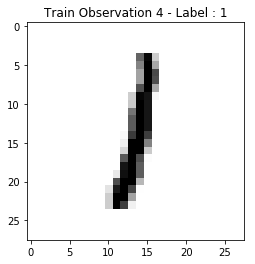

In [6]:
# load libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow import nn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib


# load data
# with one_hot=True, categorical labels (e.g. {1,2,3...}) coded into binary vector form (e.g.{[1,0,0],[0,1,0]...})
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# visual check for the loaded dataset
disp_target = 4
plt.imshow(mnist.train.images[disp_target].reshape((28,28)),cmap='gray_r')
plt.title(
    'Train Observation {:d} - Label : {:d}'.format(
        disp_target,
        np.argmax(mnist.train.labels[disp_target])
    )
)

## 2. Build MLP Architecture From Scratch

Now we will build a Multi-Layer Perceptron with 3 Fully-Connected (Dense) Layer. The structure is as below equations:

\begin{align}
h_1 & = relu(W_1 \cdot x + b_1) \\
h_2 & = relu(W_2 \cdot h_1 + b_2) \\
h_3 & = relu(W_3 \cdot h_2 + b_3) \\
o & = W_o \cdot h_3 + b_o \\
\end{align}

In [7]:
# make a inference expression w/ Variables
x = tf.placeholder(tf.float32, shape=[None,28*28])
y = tf.placeholder(tf.float32, shape=[None,10])

# 3 hidden layers
h1 = tf.contrib.layers.relu(x,100)
h2 = tf.contrib.layers.relu(h1,100)
h3 = tf.contrib.layers.relu(h2,100)

# read out layer
o = tf.contrib.layers.linear(h3,10)

# EVEN MORE SIMPLER VERSION! (!CAUTION! over simplified)
# relu_lyr = tf.contrib.layers.relu # alias
# lin_lyr = tf.contrib.layers.linear # alias
# 
# o = lin_lyr(relu_lyr(relu_lyr(relu_lyr(x,100),100),100),10)
#

### 2.3. Setup Cost Function & Get Train Op

In this section, we will define cost function for training. We will at first get a probability distribution over categories from logits by applying Softmax function. After then, it is compared with target distribution (one-hot distribution of labels). We will minimize the distance between the two distributions (inferences and labels) by categorical cross-entropy, so we will finally have a classification model for handwritten digits!

\begin{align}
\underset{W,b}{\text{min}}\frac{1}{|M|}\sum_{x,y\in M}crossentropy(y,y')\\
y' = softmax(o)\\
\end{align}

($M$ here means mini-batch)

After we compile cost function, we can have symbolic expression for its gradient. With the computation graph of tensorflow automatically calculate partial derivatives of the cost w.r.t the parametes. Then we can simply plug them in update rule, which is [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) in our case.

$$ W \leftarrow W - \alpha \cdot \frac{\partial{C}}{\partial{W}}$$

$$ b \leftarrow b - \alpha \cdot \frac{\partial{C}}{\partial{b}}$$

(we ommit the sub letters indicating layer here)

($\alpha$ is learning rate, which is usually set with small number (e.g. 0.01))

In [8]:
# set cross_entropy loss function with y (target) and o (logits)
cross_entropy = tf.reduce_mean(
    nn.softmax_cross_entropy_with_logits(
        labels=y,
        logits=o
    )
)

# then we'll get update rule (train op) here
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cross_entropy)

## 3. Traning

Now, we have every parts we need. Let's try the first run of DNN training.

Before get into running, we will prepare simple evaluation function to check it.

In [9]:
# binary accuracy calculation
correct_prediction = tf.equal(tf.argmax(o,1), tf.argmax(y,1))
# ...and its mean per feed
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Now it's show time!

0th Iteration - Train Acc: 12.00% - Test Acc: 10.14%
100th Iteration - Train Acc: 94.00% - Test Acc: 87.15%
200th Iteration - Train Acc: 95.00% - Test Acc: 89.58%
300th Iteration - Train Acc: 97.00% - Test Acc: 91.91%
400th Iteration - Train Acc: 93.00% - Test Acc: 92.19%
500th Iteration - Train Acc: 97.00% - Test Acc: 93.34%
600th Iteration - Train Acc: 97.00% - Test Acc: 94.32%
700th Iteration - Train Acc: 99.00% - Test Acc: 94.28%
800th Iteration - Train Acc: 97.00% - Test Acc: 94.58%
900th Iteration - Train Acc: 99.00% - Test Acc: 94.72%


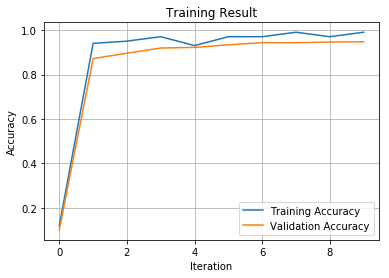

In [10]:
m = 100 # batch size
n = 1000 # number of batches to train
acc_tr = []
acc_vl = []

# Assume that you have 2GB of GPU memory and want to allocate 512MB:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)

# open an session
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    # Initialize Variables
    sess.run(tf.global_variables_initializer())

    for j in xrange(1000):
        # here we fetch a batch from dataset
        batch = mnist.train.next_batch(m)
        # update is conducted by tf
        # feed dict is key-value dictionary which
        # each keys are placeholder and
        # each values are actual value for placeholders
        sess.run(train_step,feed_dict={x:batch[0], y:batch[1]})
        
        if j%100==0:
            acc_tr.append(accuracy.eval(feed_dict={x:batch[0], y:batch[1]}))
            acc_vl.append(accuracy.eval(feed_dict={x:mnist.test.images, y:mnist.test.labels}))

            print(
                '{:d}th Iteration - Train Acc: {:.2%} - Test Acc: {:.2%}'.format(
                    j,acc_tr[-1],acc_vl[-1]
                )
            )


fig,ax = plt.subplots()
ax.plot(acc_tr, label='Training Accuracy')
ax.plot(acc_vl, label='Validation Accuracy')
ax.grid(True)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Iteration')
ax.set_title('Training Result')
ax.legend()

# Want higher level framework?

Pleas look at [Keras](https://keras.io/). this is one of the most mature high-level framework for NN.

Its aim is to make NN easier and simpler, as well as provide full functionality of its backend engine (tensorflow / theano)

Or what you want is just to build simple MLP structure as part of some application, [sklearn.neural_network](http://scikit-learn.org/stable/modules/neural_networks_supervised.html) is also very quick and fast solution.